# Use PVLIB to convert Himwari irradiance to PV output

In [7]:
import pvlib

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
from pathlib import Path

import os
import sys

from rasterstats import zonal_stats
import rasterio
import odc.geo.xr
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs

In [17]:
directory=Path('/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2020/05/05')
files = sorted(str(p) for p in directory.rglob("*.nc"))
ds = xr.open_mfdataset(files, decode_coords='all')

ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
ds.rio.write_crs("EPSG:4326", inplace=True)

ghi = ds.surface_global_irradiance
# ghi.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
# ghi.rio.write_crs("EPSG:4326", inplace=True)

# dni = ds.direct_normal_irradiance
# dni.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
# dni.rio.write_crs("EPSG:4326", inplace=True)

# dhi = ds.surface_diffuse_irradiance
# dhi.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
# dhi.rio.write_crs("EPSG:4326", inplace=True)

In [11]:
# apply urban areas mask to data, removes spatial regions note relevant to solar PV gen
shapefile = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/SOS/SOS_2021_AUST_GDA2020.shp'
gdf_sos = gpd.read_file(shapefile)
gdf_sos = gdf_sos.to_crs(ghi.rio.crs)

gdf_urban = gdf_sos[(gdf_sos['SOS_NAME21'] == 'Major Urban')  | (gdf_sos['SOS_NAME21'] == 'Other Urban')]

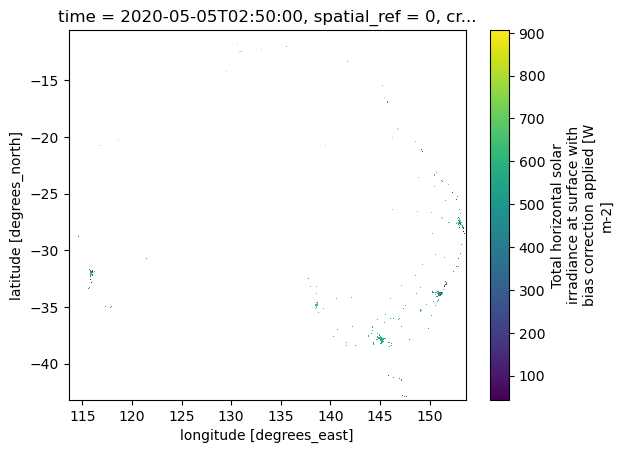

In [38]:
ds_clipped = ds.isel(time=50).rio.clip(
    gdf_urban.geometry.apply(mapping),  # Convert to GeoJSON format
    gdf_urban.crs,
    drop=True  # Drops data outside polygons
)
ghi = ds_clipped.surface_global_irradiance
ghi.plot()

In [43]:
ds_clipped = ds.rio.clip(
    gdf_urban.geometry.apply(mapping),
    gdf_urban.crs,
    drop=True
)

ghi = ds_clipped.surface_global_irradiance.values.ravel()
dni = ds_clipped.direct_normal_irradiance.values.ravel()
dhi = ds_clipped.surface_diffuse_irradiance.values.ravel()

nan_mask = np.isnan(ghi) # same for all vars
ghi_clean = ghi[~nan_mask]
dni_clean = dni[~nan_mask]
dhi_clean = dhi[~nan_mask]


# get correct time and coordinate data, so that it matches up with the remaining irradiance values
lat_1d = ds_clipped.latitude.values
lon_1d = ds_clipped.longitude.values
lon_grid, lat_grid = np.meshgrid(lon_1d, lat_1d, indexing="xy")
lat_grid_1d = lat_grid.ravel()
lon_grid_1d = lon_grid.ravel()
lat_1d_expanded = np.tile(lat_grid_1d, ds_clipped.sizes["time"])  # Tile lat for all times
lon_1d_expanded = np.tile(lon_grid_1d, ds_clipped.sizes["time"])  # Tile lon for all times
time_1d = np.repeat(ds_clipped.time.values, len(lat_grid_1d))  # Repeat time for all lat/lon
lat_1d_expanded_clean = lat_1d_expanded[~nan_mask]
lon_1d_expanded_clean = lon_1d_expanded[~nan_mask]
time_1d_clean = time_1d[~nan_mask]

In [44]:
# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

rated_capacity = module.loc['Impo'] * module.loc['Vmpo']

surface_azimuth = [0] * len(lat_1d_expanded_clean)

surface_tilt = -lat_1d_expanded_clean.ravel()

In [46]:
# Compute solar position for all grid cells at once
solpos = pvlib.solarposition.get_solarposition(
    time_1d_clean,
    lat_1d_expanded_clean,
    lon_1d_expanded_clean
)

In [47]:
# Find the angle of incidence
aoi = pvlib.irradiance.aoi(
    surface_tilt=surface_tilt.data,
    surface_azimuth=surface_azimuth,
    solar_zenith=solpos["apparent_zenith"],
    solar_azimuth=solpos["azimuth"],
)

In [72]:
# Compute air mass
airmass_relative = pvlib.atmosphere.get_relative_airmass(
    solpos['apparent_zenith'].values
)
airmass_absolute = pvlib.atmosphere.get_absolute_airmass(
    airmass_relative,
)

total_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    dni=dni_clean.ravel(),
    ghi=ghi_clean.ravel(),
    dhi=dhi_clean.ravel(),
    solar_zenith=solpos['apparent_zenith'].values,
    solar_azimuth=solpos['azimuth'].values
)

effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    poa_direct=total_irradiance['poa_direct'],
    poa_diffuse=total_irradiance['poa_diffuse'],
    airmass_absolute=airmass_absolute,
    aoi=aoi,
    module=module,
)
effective_irradiance_QC = effective_irradiance.clip(lower=0)

# Compute power
dc = pvlib.pvsystem.sapm(
    effective_irradiance=effective_irradiance_QC,
    temp_cell=np.full_like(effective_irradiance, 18), # assume temperature of 18 deg C
    module=module
)

ac = pvlib.inverter.sandia(
    v_dc=dc['v_mp'],
    p_dc=dc['p_mp'],
    inverter=inverter
)
ac_QC = np.where(ac < 0, np.nan, ac)

In [73]:
# compute ideal conditions

# get panel/solar angles for a tilting panel system
linke_turbidity = np.maximum(2 + 0.1 * airmass_absolute, 2.5) # simplified parameterisation from ChatGPT as pvlib function was not working with array
doy = pd.to_datetime(time_1d_clean).dayofyear
dni_extra = pvlib.irradiance.get_extra_radiation(doy)
ideal_conditions = pvlib.clearsky.ineichen(
    apparent_zenith=solpos['apparent_zenith'].values,
    airmass_absolute=airmass_absolute,
    linke_turbidity=linke_turbidity,
    dni_extra=dni_extra
)
ideal_total_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    dni=ideal_conditions['dni'],
    ghi=ideal_conditions['ghi'],
    dhi=ideal_conditions['dhi'],
    solar_zenith=solpos['apparent_zenith'].values,
    solar_azimuth=solpos['azimuth'].values
)
    
ideal_effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    poa_direct=ideal_total_irradiance['poa_direct'],
    poa_diffuse=ideal_total_irradiance['poa_diffuse'],
    airmass_absolute=airmass_absolute,
    aoi=tracking['aoi'],
    module=module,
)
dc_ideal = pvlib.pvsystem.sapm(
    effective_irradiance=ideal_effective_irradiance.values,
    temp_cell=np.full_like(effective_irradiance, 18), # assume temperature of 18 deg C
    module=module
)
ac_ideal = pvlib.inverter.sandia(
    v_dc=dc_ideal['v_mp'],
    p_dc=dc_ideal['p_mp'],
    inverter=inverter
)
ac_ideal_QC = np.where(ac_ideal < 0, np.nan, ac_ideal)

mask_template = ds_clipped.surface_global_irradiance
filled = np.empty_like(ghi)
filled[nan_mask] = np.nan
filled[~nan_mask] = ac_ideal_QC
reshaped = filled.reshape(mask_template.shape)

ideal_pv_output = xr.DataArray(reshaped, coords=mask_template.coords, dims=mask_template.dims)

In [51]:
mask_template = ds_clipped.surface_global_irradiance
filled = np.empty_like(ghi)
filled[nan_mask] = np.nan
filled[~nan_mask] = ac_QC
reshaped = filled.reshape(mask_template.shape)

pv_output = xr.DataArray(reshaped, coords=mask_template.coords, dims=mask_template.dims)

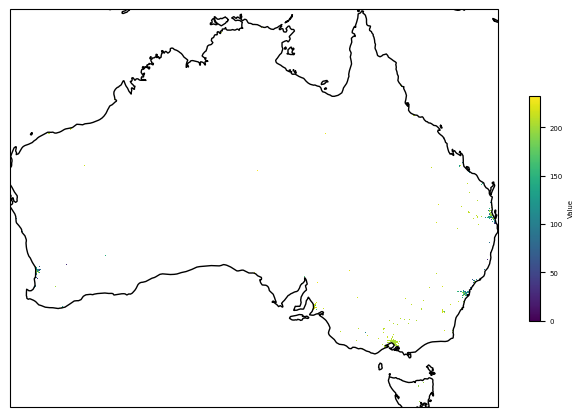

In [53]:
lon = pv_output.longitude
lat = pv_output.latitude
data = pv_output.isel(time=50)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

mesh=ax.pcolormesh(lon, lat, data, cmap='viridis',vmin=0, transform=ccrs.PlateCarree())

ax.coastlines()
cbar = plt.colorbar(mesh,ax=ax,shrink=0.5)
cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
cbar.set_label('Value', fontsize=5) 
 
plt.tight_layout()

plt.show()

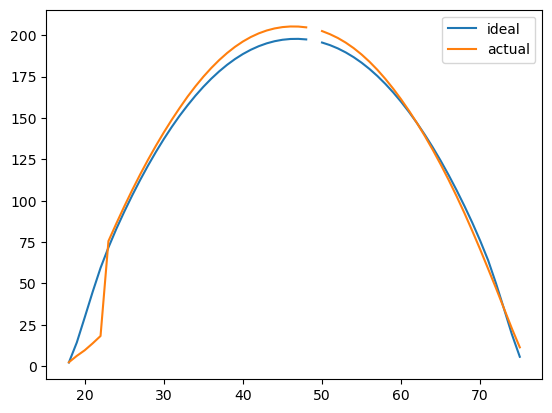

In [79]:
fig, ax = plt.subplots()

ax.plot(ideal_pv_output.sel(longitude = 144.96, latitude = -37.82), label='ideal')
ax.plot(pv_output.sel(longitude = 144.96, latitude = -37.82), label='actual')
ax.legend()

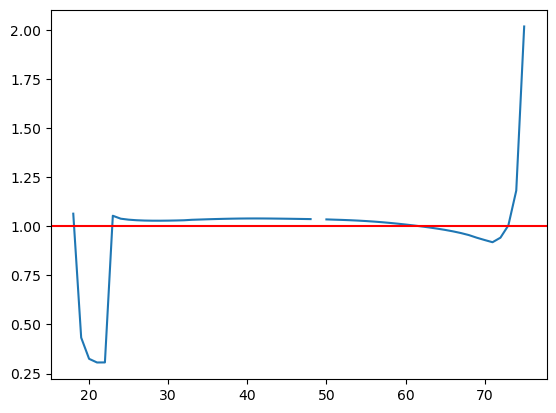

In [81]:
ideal = ideal_pv_output.sel(longitude = 144.96, latitude = -37.82)
actual = pv_output.sel(longitude = 144.96, latitude = -37.82)
ratio = actual/ideal
plt.plot(ratio)
plt.axhline(1, color='r')

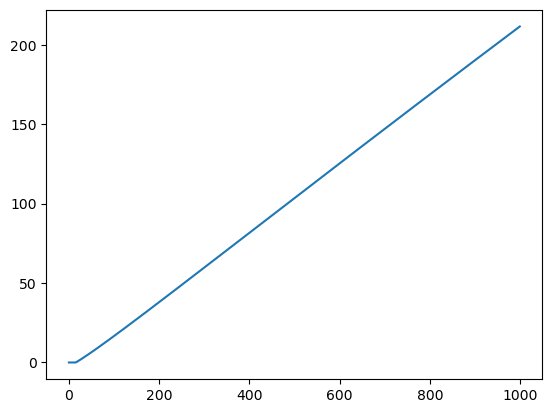

In [86]:
rad_test = []
for rad in range(1000):
    dc = pvlib.pvsystem.sapm(
        effective_irradiance=rad,
        temp_cell=25,
        module=module
    )
    ac = pvlib.inverter.sandia(
        v_dc=dc['v_mp'],
        p_dc=dc['p_mp'],
        inverter=inverter
    )
    rad_test.append(ac)
plt.plot(temp_test)

(0.0, 250.0)

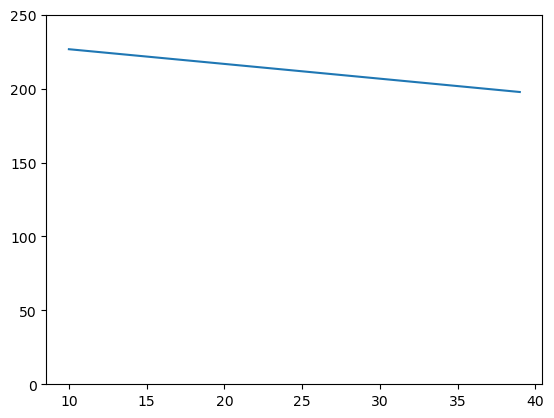

In [92]:
temp_test = []
temps = []
for temp in range(10,40):
    dc = pvlib.pvsystem.sapm(
        effective_irradiance=1000,
        temp_cell=temp,
        module=module
    )
    ac = pvlib.inverter.sandia(
        v_dc=dc['v_mp'],
        p_dc=dc['p_mp'],
        inverter=inverter
    )
    temp_test.append(ac)
    temps.append(temp)
plt.plot(temps, temp_test)
plt.ylim(0,250)